<a href="https://colab.research.google.com/github/StratagemGIS/notebooks/blob/main/data_processing/88_road_network_stats_qa_qc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vaasudevan Srinivasan 🧑🏻‍💻  
StratagemGIS Solutions

In [ ]:
%%capture
!pip install momepy

In [ ]:
import geopandas as gpd
import momepy
import networkx as nx
from more_itertools import collapse
from shapely.geometry import Point
from tqdm import tqdm

In [ ]:
# download the NBRN dataset and upload it here
# as the dataset is updated daily
nbrn = gpd.read_file(
    'geonb_nbrn-rrnb_shp.zip',
    layer='geonb_nbrn-rrnb_road-route',
    engine='pyogrio',
    use_arrow=True
).explode()

graph = momepy.gdf_to_nx(nbrn)

# Basic Stats

In [ ]:
nbrn.shape

(69683, 38)

In [ ]:
len(graph.edges), len(graph.nodes)

(69683, 58381)

In [ ]:
nbrn.TRAFFICDIR.value_counts()

,count
TRAFFICDIR,
Both Directions,64038
Same Direction,3732
Opposite Direction,1913


In [ ]:
# Top five lengthiest roads within Fredericton City
(
    nbrn
    .query('STREETNAME != "Unnamed"')
    .query('PLACE_NAME == "Fredericton"')
    .query('ST_TYPE == "Street"')
    .dissolve(by='STREETNAME')
    .assign(road_length_km=lambda df_: df_.geometry.length / 1000)
    .sort_values('road_length_km', ascending=False)
    .reset_index()
    [['STREETNAME', 'road_length_km']]
    .head(5)
)

,STREETNAME,road_length_km
0,REGENT Street,8.933184
1,PROSPECT Street,6.905208
2,CANADA Street,6.496190
3,SAINT MARY'S Street,5.532170
4,RIVER Street,4.231963


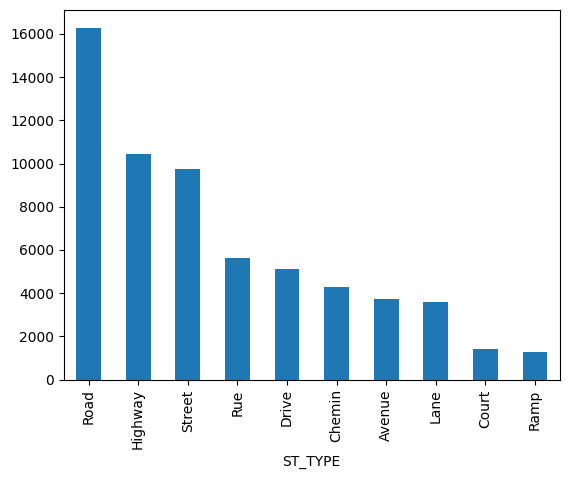

In [ ]:
nbrn.query('ST_TYPE != "None"').ST_TYPE.value_counts().head(10).plot.bar();

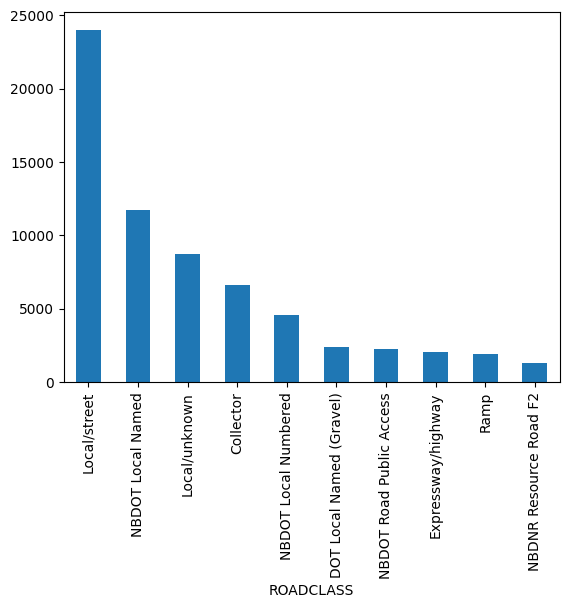

In [ ]:
nbrn.ROADCLASS.value_counts().head(10).plot.bar();

# Missing Data

In [ ]:
(
    nbrn.isna()
    .sum()
    .div(len(nbrn))
    .mul(100)
    .round(2)
    .to_frame()
    .reset_index()
    .rename(
        columns={
            'index': 'attribute',
            0: 'missing_records_percentage'
        }
    )
    .query('missing_records_percentage != 0')
    .reset_index(drop=True)
)

,attribute,missing_records_percentage
0,NID,0.43
1,PLACE_NAME,0.01
2,COUNTY,0.01


# Valid Geometry

In [ ]:
nbrn.geometry.is_valid_reason().value_counts()

,count
Valid Geometry,69683


# Isolated Roads
Road segments that do not connect to any other road segments or junctions, making them standalone features within a road network. These lines lack connectivity to the broader network

In [ ]:
# Find nodes which belong to dangled roads
nodes = list(
    collapse(
        [c for c in nx.connected_components(graph) if len(c) <= 2],
        levels=1
    )
)

# Find the roads in the network
isolated_roads = (
    gpd.sjoin(
        nbrn,
        gpd.GeoDataFrame(
            geometry=list(map(Point, nodes)),
            crs=nbrn.crs
        ),
    )
    .drop_duplicates(subset=['NID'])
)

print(isolated_roads.drop(columns=['geometry']).to_string())

                                    NID  ROADSEGID                     STREETNAME ST_TYPE TYPE_POSI PREFIX SUFFIX  NBRLANES RTENAME1EN RTENAME2EN RTENAME1FR RTENAME2FR RTNUMBER1 RTNUMBER2 STRUNAMEEN STRUNAMEFR STRUCTTYPE EXITNBR  SPEED_L  SPEED_R  SPEED SPEED_SR                        ROADCLASS PAVSTATUS   PAVSURF UNPAVSURF       TRAFFICDIR  CLOSING L_HNUMSTR R_HNUMSTR L_HNUMF L_HNUML R_HNUMF R_HNUML        PLACE_NAME          COUNTY TRAV_DIR  index_right
38108  37F2BE5B8E3F422582166ECC356325B8   11044179                        Unnamed    None         N   None   None         1       None       None       None       None      None      None    Unknown    Unknown     Bridge    None       -1       -1     -1  Unknown                    Local/unknown     Paved  Flexible      None  Both Directions  Unknown      None      None       0       0       0       0              None            None     None            0
51125  6DE5563789BA43C384A6E5B815E2DA3C   11061830  BEAUBEARS ISLAND NATURE Trai

# Closed Lines / Loop
A road or line where the start and end points are the same is called a closed line or loop.

In [ ]:
nids_closed_lines = []
for ix, rec in tqdm(nbrn.iterrows(), total=len(nbrn)):
    coords = rec.geometry.coords[:]
    if coords[0] == coords[-1]:
        nids_closed_lines.append(rec.NID)

100%|██████████| 69683/69683 [00:14<00:00, 4720.67it/s]


In [ ]:
len(nids_closed_lines)

128

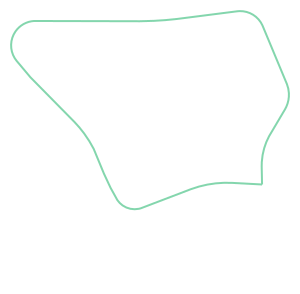

In [ ]:
nbrn.query(f'NID == "{nids_closed_lines[100]}"').geometry.squeeze()

# Duplicate vertices

In [ ]:
nid_duplicate_vertices = []
for ix, rec in tqdm(nbrn.iterrows(), total=len(nbrn)):
    coords = rec.geometry.coords[:]
    if len(coords) != len(set(coords)):
        if coords[0] != coords[-1]:
            nid_duplicate_vertices.append(rec.NID)

100%|██████████| 69683/69683 [00:11<00:00, 5807.70it/s]


In [ ]:
len(nid_duplicate_vertices)

1

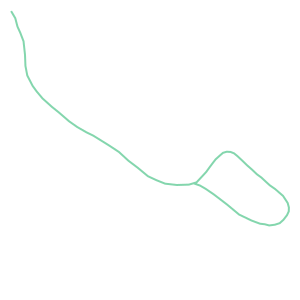

In [ ]:
nbrn.query(f'NID == "{nid_duplicate_vertices[0]}"').geometry.squeeze()